## Autora: Carmen Scartezini


# Fake News Classification - Tensorflow X Pytorch

<p align=center>
  <img src="https://img.freepik.com/fotos-gratis/conceito-de-noticias-falsas_23-2148837005.jpg?t=st=1693308306~exp=1693308906~hmac=e1b91872fdbcda0bacdf239cf76fcec1e23e63ac56d868cba6a227788a1308f9" height="30%">
</p>

Estamos vivendo na era da revolução digital, onde a informação é muito acessível, mas também enfrentamos desafios, como as Fake News. As Fake News abrangem uma ampla variedade de conteúdo enganoso, desde manipulações sutis de dados até a fabricação completa de eventos. Com a disseminação rápida da informação nas redes sociais, tornou-se crucial avaliar criticamente a autenticidade das fontes de informação que consumimos.

# O projeto

Hoje em dia, temos ferramentas que nos ajudam a identificar notícias falsas usando *Machine Learning* e **Deep Learning** que podem distinguir notícias falsas de informações reais.

Vamos usar esse tema para comparar as bibliotecas TensorFlow e Pytorch na construção de um classificador de notícias falsas.

**O objetivo deste projeto é construir um modelo PyTorch para desenvolver um framework de previsão semelhante ao que já foi construído no TensorFlow e, posteriormente, comparar esses modelos criados em ambos os ambientes.**

Para isso, usaremos o conjunto de dados WELFake, que combina quatro conjuntos de dados de notícias proeminentes (Kaggle, McIntire, Reuters e BuzzFeed Political), resultando em uma coleção abrangente de 72.134 artigos de notícias. Entre eles, há 35.028 artigos de notícias reais e 37.106 fabricados. Para esse projeto utilizamos metade desses dados em decorrencia da capacidade computacional e tempo de treinamento disponiveis.

O artigo de publicação do conjunto de dados pode ser rastreado em [IEEE Transactions on Computational Social Systems: pp. 1-13](https://doi.org/10.1109/TCSS.2021.3068519)

O Dataset foi importado via API com [Kaggle](https://www.kaggle.com/datasets/vcclab/welfake-dataset)

### Importando Pacotes e definindo funções

In [23]:
# importando pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
!pip install kaggle
import zipfile
from IPython.display import FileLink
from pathlib import Path
import shutil
import torch
import zipfile
import csv
import string
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
import torchtext.vocab as vocab
import collections
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler
from time import time
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import re


# notebook configs
np.random.seed(42)
sns.set_style()

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Definindo funções
def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

### Fazendo a conexão com os dados pela API do Kaggle

In [3]:
# configurando local de armazenamento do arquivo
kaggle_dir = Path("~/.kaggle").expanduser()
kaggle_dir.mkdir(parents=True, exist_ok=True)

# mudando permissões
(kaggle_dir / "kaggle.json").chmod(0o600)

# endereço de API
!kaggle datasets download -d vcclab/welfake-dataset


welfake-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# caminho do arquivo baixado
path_to_zip_file = r'C:\Users\carmenscartezini\Desktop\projects\welfake-dataset.zip'

# Diretório para extração do arquivo
directory_to_extract_to = r'C:\Users\carmenscartezini\Desktop\projects'

# Extração do arquivo zipado
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
df = pd.read_csv(r'C:\Users\carmenscartezini\Desktop\projects\WELfake_dataset.csv')

In [5]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


### Metadata

* `title` - Título das mensagens
* `text` - Texto contido das mensagens
* `label` é o nosso target onde:
  * True (Real) = 0
  * Fake (Falso) = 1

### Data Preprocessing

Quando lidamos com dados de texto no formato `string`, como demonstrado no código fornecido, aplicamos técnicas de Processamento de Linguagem Natural (NLP) para otimizar os dados para o nosso modelo. Nesse caso, o código exemplifica etapas de pré-processamento de texto, como a conversão do texto para letras minúsculas, remoção de pontuação e a aplicação dessas alterações em todo o conjunto de dados. Essas etapas de pré-processamento contribuem para aprimorar a capacidade do modelo de processar os dados com precisão e produzir os resultados desejados.

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [8]:
df.dropna(subset=['text'], inplace=True)

In [9]:
df = df.fillna('') # Preenchendo nulos com espaços vazios

In [10]:
df["title_text"] = df["title"] + df["text"]
df.head()

,title,text,label,title_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


In [11]:
df.drop(["title", "text"], axis=1, inplace=True)

In [12]:
#Dividindo os dados ao meio
df,_ = train_test_split(df, test_size=0.5, random_state=42)

In [13]:
df.label.value_counts()

1    18510
0    17537
Name: label, dtype: int64

## Feature Engineering
No Kaggle os notebooks sobre o tema costumam criar uma nova feature: body_len
E normalmente nesse contexto, nos notebooks avaliados, o tamanho do texto parece ser um bom indicador de fake news.


In [14]:
df["body_len"] = df["title_text"].apply(lambda x: len(x) - x.count(" "))

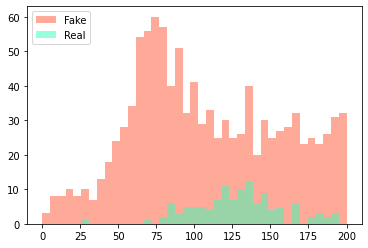

In [15]:
bins = np.linspace(0, 200, 40)

plt.hist(df[df["label"]== 1]["body_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(df[df["label"]== 0]["body_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.show()

Para criação de novas features, pensando em quais atributos no texto poderiam indicar fake news. Pensamos que seria interessante criar uma feature que conte quantas palavras estão em capslock no texto pra entender se este atributo também poderia ser um indicador pra incluir no modelo.

In [19]:
def count_capslock_words(text):
    words = re.findall(r'\b[A-Z]+\b', text)
    return len(words)

# Aplicar a função para contar palavras em caixa alta e armazenar em uma nova coluna
df['capslock_word_count'] = df['title_text'].apply(count_capslock_words)

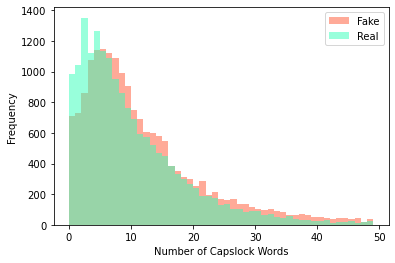

In [20]:
bins = range(0,50)
plt.hist(df[df["label"] == 1]["capslock_word_count"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(df[df["label"] == 0]["capslock_word_count"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper right")
plt.xlabel("Number of Capslock Words")
plt.ylabel("Frequency")
plt.show()

Neste caso, essa feature não parece ter diferenças estatisticas relevantes para que usemos no modelo.
De qualquer forma, neste modelo só iremos usar a feature 'title_text'.

In [21]:
df['title_text'] = df['title_text'].apply(clean_text)
df.head()

,label,title_text,body_len,capslock_word_count
37527,1,federal judge charges sheriff joe with c...,677,3
29526,1,you can’t make this up black man wins ...,1538,12
59388,0,trump expected to make vp announcement o...,845,5
10814,0,sweden stops some new aid for cambodia ...,2489,9
25282,0,britains labour says may should consider ...,752,2


In [22]:
X= df[['title_text']]
y= df[['label']]

Dividindo os dados em treino, validação e teste

In [20]:
# Dividindo em Treino, teste e validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# tamanho dos dfs
print("Train data size:", len(X_train))
print("Validation data size:", len(X_val))
print("Test data size:", len(X_test))

Train data size: 25232
Validation data size: 5407
Test data size: 5408


### Tokenization 
A tokenização é uma técnica de processamento de texto que envolve a divisão de longas sequências de texto em unidades menores, chamadas de tokens. A tokenização é uma etapa fundamental em tarefas de processamento de linguagem natural, pois permite que as máquinas processem e compreendam dados textuais de maneira mais eficaz. Ela serve como base para diversas tarefas relacionadas à linguagem, como modelagem de linguagem, análise de sentimentos e tradução automática.

<p align=center>
  <img src="https://ambrapaliaidata.blob.core.windows.net/ai-storage/articles/22_8Jmr9FY.png" height="30%">
</p>


### Tensorflow
O processo de tokennização no tensorflow me parece mais simples pois já temos uma função na qual você pode definir o número máximo de palavras do vocabulário (vocab_size) que você gostaria de utilizar no modelo (isso pode ajudar a melhorar a performance do modelo, mas não utilizar todas as palavras do vocabulário dos dados também pode fazer com que você perca dados) e outras funções que automatizam pequenos processos de tratamento de dados até na aplicação do modelo em si.

A função `tokenizer` atribui um numero/indice para cara palavra, além dessa outras funções são aplicadas: `training_sequences` é uma lista de listas, onde cada lista interna contém os índices que representam as palavras nas sequências de texto de treinamento. Essa função deve ser aplicada aos dados porque o computador entende números e não palavras.

Com a função `pad_sequences` você garante que todas as sequências de entrada tenham o mesmo comprimento. Isso ocorre porque nossas matrizes precisam ter o mesmo tamanho para que nossa rede funcione. As palavras fora do limite do vocabulario são preenchidas com zeros.

Para isso no tensorflow utilizamos 16 linhas de código.

Esse modelo do tensorflow é uma cópia de um modelo já feito pelo autor **Carlos Melo Sigmoidal** em seus cursos de machine Learning. Utilizei o modelo dele que já funcionava nesse contexto de dados, reaplicando o modelo dele ao meu conjunto de dados a fim de comparação dos modelos gerados em ambas bibliotecas. 

A partir desse modelo, desenvolvi um modelo similar no Pytorch.

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.title_text)
word_index = tokenizer.word_index

Aplicando técnicas tokenizing e padding
training_sequences = tokenizer.texts_to_sequences(np.array(train.title_text))
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.title_text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

Criando arrays com inputs - tensors
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['label'].values
y_val = validation['label'].values

### Pytorch
No Pytorch já não temos as funções acima citadas como as que que tem o papel de definir o tamanho máximo do vocabulario para a tokenização,ou que define as sequencias(training_sequences) e transforma essa sequencia com padding(training_padded).
Por isso vamos criar essas funções do zero para usarmos no código.
Para construir funções similares as descritas no tensorflow (16 linhas de código) , utilizamos 49 linhas de código no Pytorch

In [ ]:
# Função para converter sequências de tokens em índices
def generate_indices(sequences, word_to_idx):
    return [[word_to_idx.get(token, word_to_idx[oov_tok]) for token in sequence] for sequence in sequences]

# Converta as sequências de índices em tensores PyTorch e faça o padding
def sequences_to_tensors(sequences):
    tensor_sequences = [torch.tensor(sequence) for sequence in sequences]
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=0)
    return padded_sequences

def build_vocab(sequences, vocab_size, oov_token):
    word_to_idx = {"<PAD>": 0, oov_token: 1}  # Inclua tokens especiais
    idx = 2  # Índice para as próximas palavras
    word_count = {}  # Contador de palavras

    for sequence in sequences:
        for token in sequence:
            if token not in word_count:
                word_count[token] = 1
            else:
                word_count[token] += 1

    # Ordene as palavras pelo contador (em ordem decrescente) e adicione ao vocabulário
    sorted_words = sorted(word_count.keys(), key=lambda x: word_count[x], reverse=True)

    for word in sorted_words[:vocab_size - 2]:  # Reserve espaço para <PAD> e <OOV>
        word_to_idx[word] = idx
        idx += 1

    return word_to_idx

In [21]:
# Defina o tamanho máximo do vocabulário (vocab_size)
vocab_size = 10000
oov_tok = "<OOV>"

# Crie o tokenizer
tokenizer = get_tokenizer('basic_english')

# Tokenize seus dados de treinamento, validação e teste
train_sequences = [tokenizer(sample) for sample in X_train['title_text']]
validation_sequences = [tokenizer(sample) for sample in X_val['title_text']]
test_sequences = [tokenizer(sample) for sample in X_test['title_text']]

# Construa o vocabulário com o tamanho máximo desejado
word_to_idx = build_vocab(train_sequences, vocab_size, oov_tok)

# Converta as sequências de tokens em índices
train_indices = generate_indices(train_sequences, word_to_idx)
validation_indices = generate_indices(validation_sequences, word_to_idx)
test_indices = generate_indices(test_sequences, word_to_idx)

# Converta as sequências de índices em tensores PyTorch e faça o padding
train_padded = sequences_to_tensors(train_indices)
validation_padded = sequences_to_tensors(validation_indices)
test_padded = sequences_to_tensors(test_indices)

# Converta os rótulos alvo para tensores PyTorch
y_train = torch.tensor(y_train['label'].values)
y_val = torch.tensor(y_val['label'].values)
y_test = torch.tensor(y_test['label'].values)

x_train_tensor = torch.tensor(train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  

x_val_tensor = torch.tensor(validation_padded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32) 

batch_size = 32  # Defina o tamanho do lote desejado

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)


## Preparando, Instanciando, e treinando o Modelo
Agora que nossos dados estão preparados, vamos aos modelos.

### Tensorflow

O tensorflow é mais 'pronto pra uso'. Temos APIs e funções mais automatizadas para aplicação do modelo.

Explicações do modelo do tensorflow:
- **tf.keras.Sequential:** cria uma camada sequencial pra rede neural onde saída de uma camada é a entrada para a próxima.
- **tf.keras.layers.Embedding:** Ela converte os índices inteiros das palavras em vetores densos. vocab_size é o tamanho do vocabulário, 155 é a dimensão dos vetores de incorporação e input_length é o comprimento máximo das sequências de entrada.
- **tf.keras.layers.Conv1D:** Esta é uma camada de convolução 1D que é usada para aprender representações de características a partir dos dados de entrada. Ela tem 16 filtros de tamanho 5 e usa a função de ativação 'relu'.
- **tf.keras.layers.GlobalMaxPooling1D():**  Essa camada executa o max-pooling global sobre a saída da camada de convolução. Isso significa que ele pega o valor máximo de cada filtro em toda a sequência.
- **tf.keras.layers.Dense:** Essa camada é comumente usada em tarefas de classificação binária (por isso o isso da função de ativação sigmoide), onde você deseja obter uma probabilidade.
- **model.compile:** Este código configura um modelo de rede neural para treinamento. Ele define a função de perda como 'binary_crossentropy' para problemas de classificação binária, usa o otimizador Adam com uma taxa de aprendizado de 0.001 para ajustar os pesos do modelo e acompanha a métrica de precisão durante o treinamento para avaliar o desempenho do modelo.
- **model.fit:** Este código realiza o treinamento do modelo neural. Ele ajusta o modelo aos dados de treinamento (x_train e y_train) por 3 épocas, registrando informações verbosas de treinamento com verbose=2. Além disso, usa dados de validação (x_val e y_val) para avaliação durante o treinamento

Em 10 linhas de  código conseguimos fazer todas  essas etapas

<p align=center>
  <img src="https://github.com/carmenscar/photos-for-notebooks/blob/main/acc_loss_tensor.png?raw=true" height="30%">
</p>

Veja a acurácia e a perda [aqui](https://github.com/carmenscar/photos-for-notebooks/blob/main/acc_loss_tensor.png?raw=true)

### Pytorch
Temos uma programação mais orientada a objeto no Pytorch. Assim precisamos definir as funções.
Para utilizarmos um modelo similar ao utilizado no tensorflow, utilizamos a mesma estrutura de rede com os mesmos: número de camadas, tipo de camadas, tamanho do vocabulario, tamanho das dimensões de embedding, funções de ativação, tamanho do learning rate, dentre outros.

Para construir esse código utilizamos aproximadamente 69 linhas de codigo.

In [28]:
class CustomModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length):
        super(CustomModel, self).__init__()        
        # Camada de embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Camada 1D Convolutional Layer com função de ativação 'relu'
        self.conv1d = nn.Sequential(nn.Conv1d(embedding_dim, 16, kernel_size=5),
                                    nn.ReLU())  
        # Camada Global Max Pooling 
        self.global_maxpooling = nn.AdaptiveMaxPool1d(1)
        # Camada com função de ativação 'sigmoid' 
        self.dense = nn.Sequential(nn.Linear(16, 1),
                                   nn.Sigmoid()) 
    
    def forward(self, x):
        # Embedding 
        x = self.embedding(x)
        # Transpondo dimensões para aplicação na camada convolucional
        x = x.permute(0, 2, 1)
        # 1D Convolutional - 'relu'
        x = self.conv1d(x)
        # Global max pooling
        x = self.global_maxpooling(x)
        # 'sigmoid' 
        x = self.dense(x.squeeze(2))
        
        return x

In [24]:
# Define o modelo
vocab_size = 10000  
embedding_dim = 155  
max_length = train_padded.shape[1]   
model = CustomModel(vocab_size, embedding_dim, max_length)

# Define uma função de perda e otimizador
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)  


In [25]:
# Listas para armazenar a perda média e a acurácia média em cada época
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Treinamento
num_epochs = 3  # Número de épocas de treinamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        
        # Zere os gradientes
        optimizer.zero_grad()
        # Passe os dados pelo modelo
        outputs = model(batch_inputs)
        # Redimensione os rótulos para ter o mesmo formato que as saídas do modelo
        batch_labels = batch_labels.view(-1, 1)
        # Calcule a perda
        loss = criterion(outputs, batch_labels)
        # Calcule a acurácia de treinamento
        predictions = (outputs > 0.5).float()
        correct_train += (predictions == batch_labels).sum().item()
        total_train += batch_labels.size(0)
        
        # Retropropagação e otimização
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calcule a perda média e a acurácia média de treinamento para a época
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Validação
    model.eval()
    total_correct = 0
    total_samples = 0
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            
            # Passe os dados pelo modelo
            outputs = model(batch_inputs)
            
            # Redimensione os rótulos para ter o mesmo formato que as saídas do modelo
            batch_labels = batch_labels.view(-1, 1)
            
            # Calcule a perda de validação
            val_loss = criterion(outputs, batch_labels)
            
            # Calcule a acurácia de validação
            predictions = (outputs > 0.5).float()
            total_correct += (predictions == batch_labels).sum().item()
            total_samples += batch_labels.size(0)
            total_val_loss += val_loss.item()
    
    # Calcule a perda média e a acurácia média de validação para a época
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_correct / total_samples
    
    # Armazene os valores em histórico
    train_loss_history.append(average_train_loss)
    val_loss_history.append(average_val_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs},")
    print(f"Training Loss: {average_train_loss:.4f},")
    print(f"Training accuracy: {train_accuracy * 100:.2f}%,")
    print(f"Validation Loss: {average_val_loss:.4f},")
    print(f"Validation acurracy: {val_accuracy * 100:.2f}%")



Epoch 1/3,
Training Loss: 0.2211,
Training accuracy: 90.70%,
Validation Loss: 0.1198,
Validation acurracy: 95.47%
Epoch 2/3,
Training Loss: 0.0932,
Training accuracy: 96.67%,
Validation Loss: 0.0961,
Validation acurracy: 96.15%
Epoch 3/3,
Training Loss: 0.0506,
Training accuracy: 98.48%,
Validation Loss: 0.0879,
Validation acurracy: 96.41%


# Analisando as métricas do modelo
Como a arquitetura, estrutura e parametros utilizados por ambos modelos (no pytorch e no tensorflow), os resultados de acurácia e perda também são semelhantes como evidenciado nos gráficos abaixo.

### Tensorflow

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

<p align="center">
  <img src="https://github.com/carmenscar/photos-for-notebooks/blob/main/loss_graphic_tensor.png?raw=true" >
</p>

<p align="center">
  <img src="https://github.com/carmenscar/photos-for-notebooks/blob/main/acc_graphic_tensor.PNG?raw=true" >
</p>

Veja aqui a [perda](https://github.com/carmenscar/photos-for-notebooks/blob/main/loss_graphic_tensor.png?raw=true) e [acurácia](https://github.com/carmenscar/photos-for-notebooks/blob/main/acc_graphic_tensor.PNG?raw=true) no nosso modelo do tensorflow

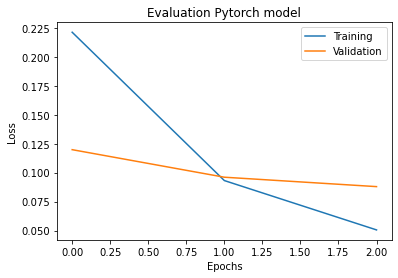

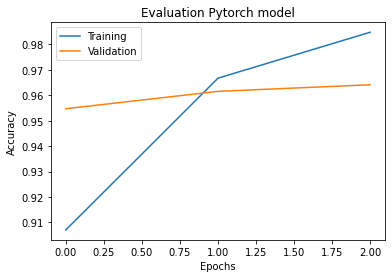

In [32]:
# Função para plotar gráficos
import matplotlib.pyplot as plt

def plot_graphs(train_history, val_history, string):
    plt.plot(train_history, label='Training')
    plt.plot(val_history, label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Evaluation Pytorch model')
    plt.legend()
    plt.show()

# Plotar gráficos de perda e acurácia
plot_graphs(train_loss_history, val_loss_history, 'Loss')
plot_graphs(train_accuracy_history, val_accuracy_history, 'Accuracy')

##  Predict
Para a função predict no tensoflow, podemos aplicar o código abaixo

### Tensorflow

test_sequences = tokenizer.texts_to_sequences(np.array(test.title_text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

preds = np.round(model.predict(test_padded))

acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["label"].values)) / len(test)
print("Accuracy: ", acc )

### Pytorch
Os proximos passos, seria criar a função predict para o tensorflow e medir a acurária do teste set.

# Conclusões

PyTorch e TensorFlow são frameworks de **Deep Learning** com abordagens diferentes. PyTorch oferece flexibilidade orientada por Python, permitindo que você construa sua própria lógica de treinamento e use DataLoaders personalizados. TensorFlow, por outro lado, fornece APIs de alto nível, como o Keras, automatizando muitos aspectos do treinamento e carregamento de dados.

A escolha entre PyTorch e TensorFlow depende das preferências e requisitos do projeto. Ambos são capazes de realizar tarefas semelhantes, mas oferecem diferentes níveis de controle. Portanto, as funções são semelhantes em ambos os modelos, mas as implementações podem variar um pouco devido às diferenças entre as bibliotecas.

Além disso, o Feature engineering pode ser aplicada para melhorar os modelos. Nesse contexto, observamos que palavras em maiúsculas não parecem ser estatisticamente relevantes para indicar uma maior probabilidade de o texto ser falso. Mas 'body_len' poderia melhorar o desempenho do modelo.

Embora os resultados sejam promissores, investigações adicionais são necessárias para melhorias. No entanto, conseguimos construir uma rede neural simples, com resultados semelhantes entre PyTorch e TensorFlow.

## Autor: Carmen Scartezini